In [ ]:
import torch
print(torch.__version__)

import torchvision
from torchvision import datasets, transforms

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, )
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, )

print(len(mnist_trainset))
print(len(mnist_testset))

1.9.0+cu102



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000
10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


4
torch.Size([784])


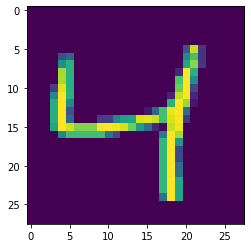

In [ ]:
import matplotlib.pyplot as plt

i = 2
example = mnist_trainset[i]
img = example[0]
label = example[1]
plt.imshow(img)
print(label)

trans = transforms.ToTensor()
tensor = trans(img).view(28*28)
print(tensor.shape)

In [ ]:
import torch.nn as nn

W1 = torch.nn.Parameter(torch.zeros(32, 794).uniform_(-0.1, 0.1))
b = torch.nn.Parameter(torch.zeros(32).uniform_(-0.1, 0.1))
W2 = torch.nn.Parameter(torch.zeros(2, 32).uniform_(-0.1, 0.1))

W3 = torch.nn.Parameter(torch.zeros(64, 138).uniform_(-0.1, 0.1))
c = torch.nn.Parameter(torch.zeros(64).uniform_(-0.1, 0.1))
W4 = torch.nn.Parameter(torch.zeros(784, 64).uniform_(-0.1, 0.1))

print(b)

Parameter containing:
tensor([ 0.0064,  0.0508, -0.0178, -0.0323, -0.0510,  0.0267,  0.0395, -0.0736,
         0.0972, -0.0263,  0.0102,  0.0491,  0.0872, -0.0790, -0.0314, -0.0237,
        -0.0498, -0.0523,  0.0647, -0.0113, -0.0049,  0.0649, -0.0286,  0.0983,
        -0.0024,  0.0351, -0.0296, -0.0013,  0.0475,  0.0964,  0.0659,  0.0440],
       requires_grad=True)


In [ ]:
import math
lr1 = 4e-5
lr2 = 1e-4
k = 3
import random

optimizer1 = torch.optim.Adam([W1, b, W2], lr=lr1)
optimizer2 = torch.optim.Adam([W3, c, W4], lr=lr2)

losses1 = []
updates1 = []
update1 = 0

losses2 = []
updates2 = []
update2 = 0

accuracyX = []
accuracyXs = []

accuracyG = []
accuracyGs = []

import tqdm
for epoch in range(30):
  for num in tqdm.tqdm(range(len(mnist_trainset))):
    i = random.randint(0, len(mnist_trainset)-1)
    example = mnist_trainset[i]
    label = example[1]
    X = torch.zeros(10)
    X[label] = 1
    img = example[0]
    tensor = trans(img).view(28*28)
    Xtensor = torch.cat((X, tensor), 0)
    z = torch.randn(128)
    
    for j in range(k):
      optimizer1.zero_grad()
      G = W4 @ torch.relu(W3 @ torch.cat((X, z), 0) + c)
      XG = torch.cat((X, G), 0)
      D = W2 @ torch.relu(W1 @ Xtensor + b)
      DG = W2 @ torch.relu(W1 @ XG.detach() + b)
      Dexp = torch.exp(D)
      Dsum = torch.sum(Dexp)
      DGexp = torch.exp(DG)
      DGsum = torch.sum(DGexp)
      loss1 = -torch.log(Dexp[0]/Dsum) - torch.log(1 - DGexp[0]/DGsum)
      update1 += 1
      accuracyX = torch.argmax(Dexp)
      accuracyXs.append(accuracyX)
      accuracyG = torch.argmax(DGexp)
      accuracyGs.append(accuracyG)
      updates1.append(update1)
      losses1.append(loss1.item())
      loss1.backward()
      optimizer1.step()
    
    optimizer2.zero_grad()
    G = W4 @ torch.relu(W3 @ torch.cat((X, z), 0) + c)
    DG = W2 @ torch.relu(W1 @ torch.cat((X, G), 0) + b)
    DGexp = torch.exp(DG)
    DGsum = torch.sum(DGexp)
    loss2 = torch.log(1 - DGexp[0]/DGsum)
    update2 += 1
    updates2.append(update2)
    losses2.append(loss2.item())
    loss2.backward()
    optimizer2.step()

100%|██████████| 60000/60000 [05:13<00:00, 191.48it/s]


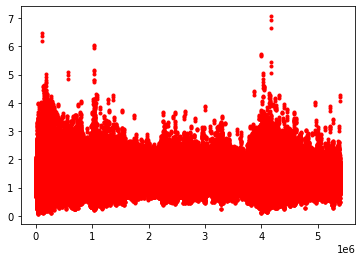

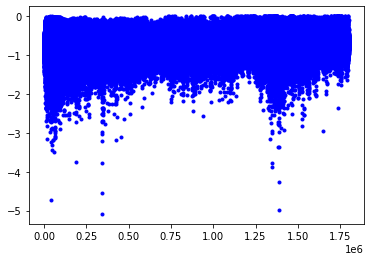

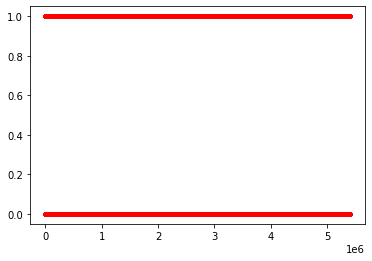

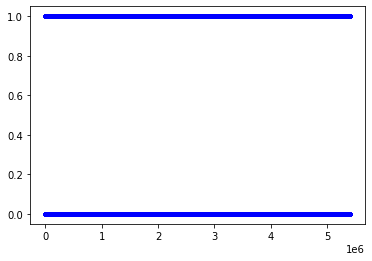

In [ ]:
import matplotlib.pyplot as plt
plot1 = plt.figure(1)
plt.plot(updates1, losses1, 'r.')

plot2 = plt.figure(2)
plt.plot(updates2, losses2, 'b.')

plot3 = plt.figure(3)
plt.plot(updates1, accuracyXs, 'r.')

plot4 = plt.figure(4)
plt.plot(updates1, accuracyGs, 'b.')

plt.show()

torch.Size([784])


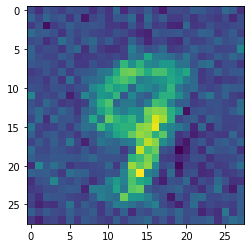

In [ ]:
labeltest = 9
Xtest = torch.zeros(10)
Xtest[labeltest] = 1
ztest = torch.randn(128)
test = W4 @ torch.relu(W3 @ torch.cat((Xtest, ztest), 0) + c)
print(test.shape)
plt.imshow(test.view(28,28).detach())